In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections

## Post-processing utilities

In [2]:
def get_request_times(df):
    "Get all request times across all runs"
    return pd.concat(
        [
            pd.DataFrame(df.loc[i, 'request_data'])['total_response_time_in_ms']
            for i in range(len(df))
        ]
    )


def get_first_request_start(df):
    "Get the start of the first request during a run"
    return pd.DataFrame(df['request_data'])['request_start'].min()


def get_last_request_end(df):
    "Get the end of the last request during a run"
    return pd.DataFrame(df['request_data'])['response_end'].max()


def get_number_of_requests(df):
    "Get the number of requests during a run"
    return len(pd.DataFrame(df['request_data'])['total_response_time_in_ms'])


def get_slowest_response_time(df):
    "Get the length of the slowest request during a run"
    return pd.DataFrame(df['request_data'])['total_response_time_in_ms'].max()


def get_first_frame_start(df):
    "Get the start of the first frame during a run"
    return min(df['frame_starts_in_ms'])


def get_last_frame_end(df):
    "Get the end of the last frame during a run"
    return max(df['frame_ends_in_ms'])


def get_number_of_frames(df):
    "Get the number of frames"
    return len(df['frame_ends_in_ms'])


def get_frame_durations(df):
    "Get all frame durations across all runs"
    return pd.concat([pd.DataFrame(df.loc[i, 'frame_durations_in_ms']) for i in range(len(df))])


def get_frame_starts(df):
    "Get all frame starts across all runs"
    return pd.concat([pd.DataFrame(df.loc[i, 'frame_starts_in_ms']) for i in range(len(df))])

## Read data from benchmarks

In [3]:
df_aws = pd.read_json('../data/data-2023-06-22T16-22-08.json')
df_azure = pd.read_json('../data/data-2023-06-21T16-28-43.json')
df_local = pd.read_json('../data/data-2023-06-21T17-37-37.json')
df_combined = pd.concat([df_aws, df_azure, df_local])

## Post process

In [4]:
def postprocess(df):
    for column, function in [
        ('slowest_request_in_ms', get_slowest_response_time),
        ('number_of_requests', get_number_of_requests),
        ('requests_start', get_first_request_start),
        ('requests_end', get_last_request_end),
        ('frames_start', get_first_frame_start),
        ('frames_end', get_last_frame_end),
        ('number_of_frames', get_number_of_frames),
    ]:
        df[column] = df.apply(lambda x: function(x), axis=1)
    df['requests_total_duration'] = df['requests_end'] - df['requests_start']
    df['frames_total_duration'] = df['frames_end'] - df['frames_start']
    df['frames_requests_overlap'] = df['requests_end'] - df['frames_start']
    df['provider'] = pd.Categorical(df['provider'])

In [5]:
for df in [df_aws, df_azure, df_local, df_combined]:
    postprocess(df)

### Determine if any runs have fewer than the expected number of requests

In [6]:
len(df_combined[df_combined['number_of_requests'] < 11])

0

## Plot requests and frame durations for each run

In [7]:
def plot_runs(df):
    fig, ax = plt.subplots(nrows=len(df), figsize=(10, len(df) * 2), sharex=True)
    for ind, run in df.iterrows():
        requests = (
            pd.DataFrame(run['request_data'])
            .sort_values(by="total_response_time_in_ms")
            .reset_index()
        )
        for i, request in requests.iterrows():
            ax[ind].hlines(i, request['request_start'], request['response_end'], colors='red')
            ax[ind].text(request['response_end'] + 25, i, request['url'].split('/')[-1])
        ax[ind].set(yticklabels=[])
        ax[ind].tick_params(left=False)
        ax[ind].set_title(f'Run {ind}; {run["provider"]}', loc='left')
        ax[ind].hlines(
            np.linspace(0, len(requests), len(run["frame_starts_in_ms"])),
            run["frame_starts_in_ms"],
            run["frame_ends_in_ms"],
            colors='blue',
        )
    ax[ind].set_xlabel('Time (ms)')

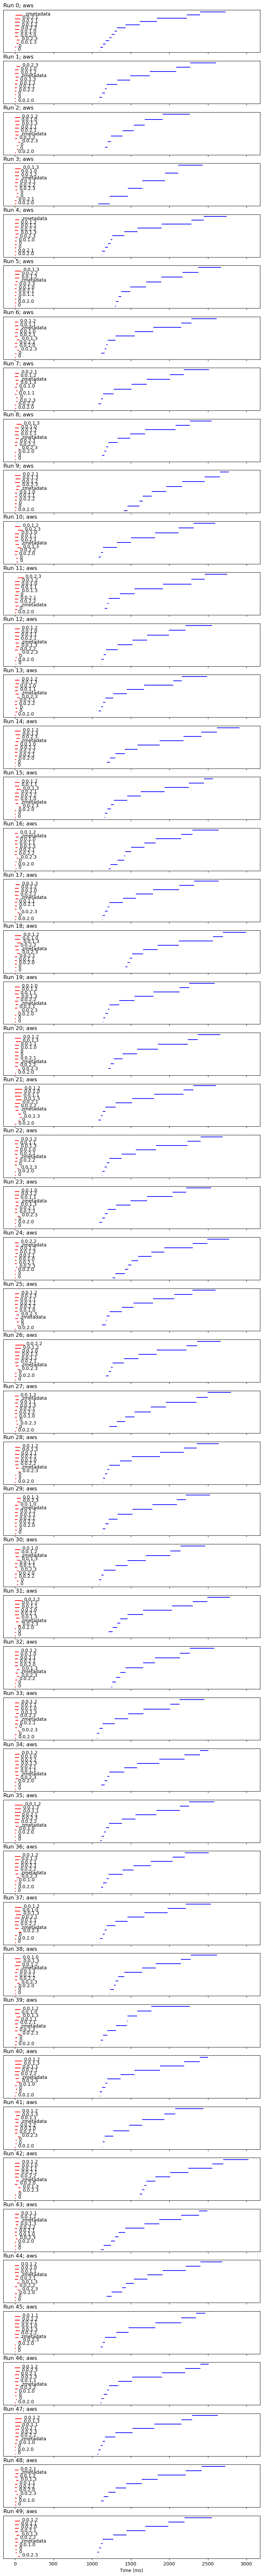

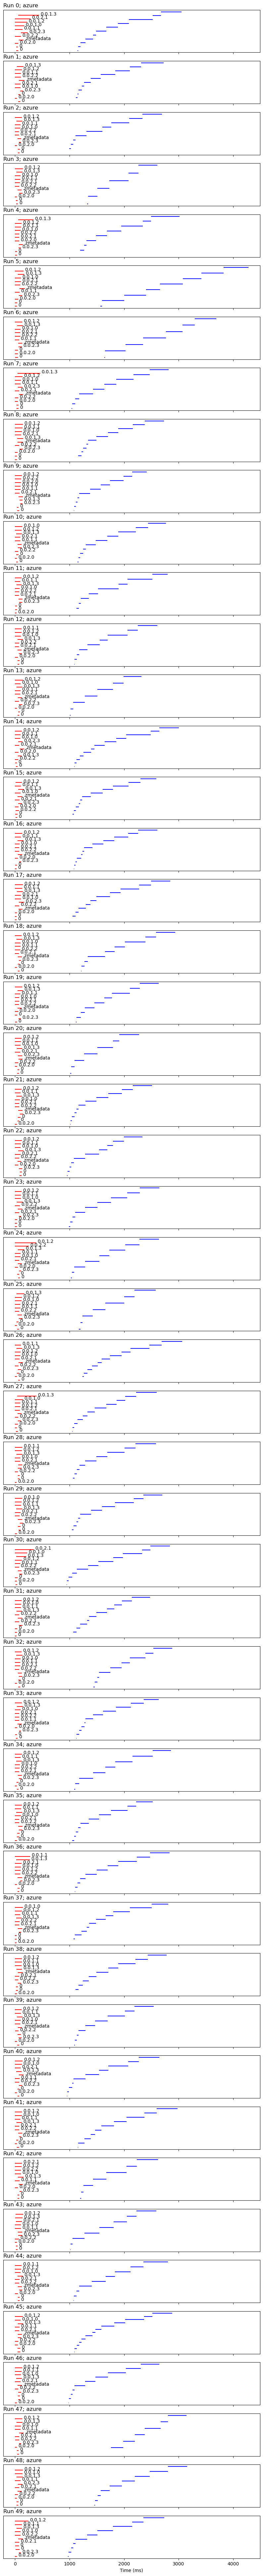

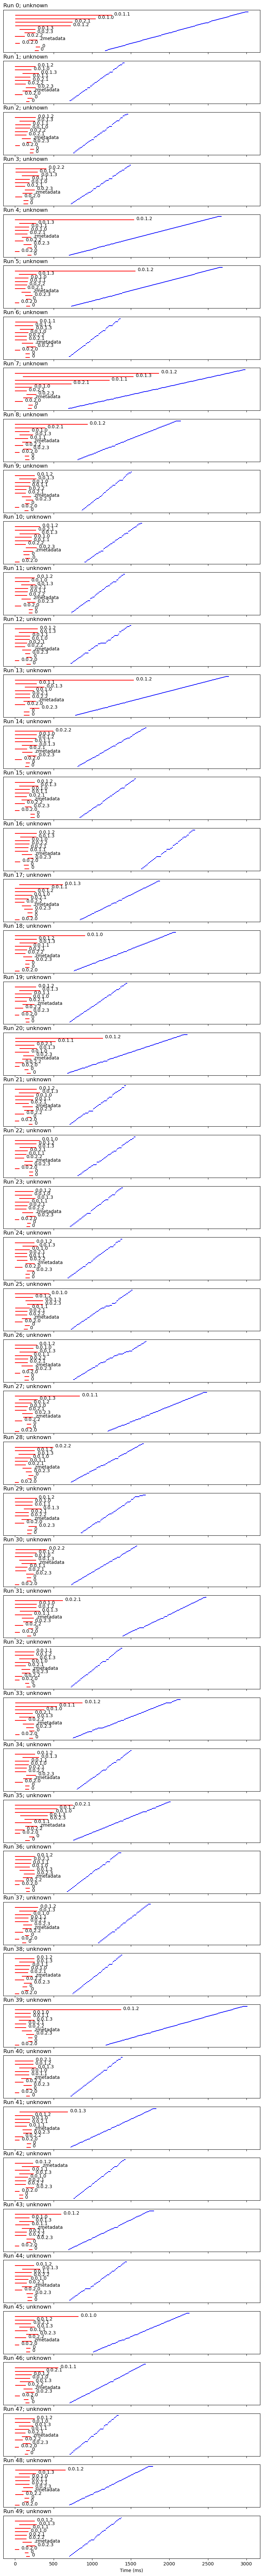

In [8]:
for df in [df_aws, df_azure, df_local]:
    plot_runs(df)

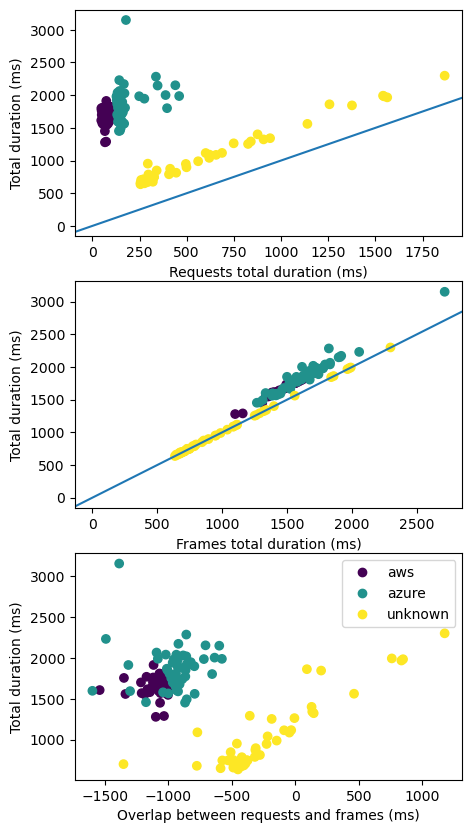

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
s = ax[0].scatter(
    df_combined['requests_total_duration'],
    df_combined['total_duration_in_ms'],
    c=df_combined['provider'].cat.codes,
)
ax[0].set_xlabel('Requests total duration (ms)')
ax[0].set_ylabel('Total duration (ms)')
ax[0].axline((0, 0), slope=1)
s = ax[1].scatter(
    df_combined['frames_total_duration'],
    df_combined['total_duration_in_ms'],
    c=df_combined['provider'].cat.codes,
)
ax[1].set_xlabel('Frames total duration (ms)')
ax[1].set_ylabel('Total duration (ms)')
ax[1].axline((0, 0), slope=1)
s = ax[2].scatter(
    df_combined['frames_requests_overlap'],
    df_combined['total_duration_in_ms'],
    c=df_combined['provider'].cat.codes,
)
ax[2].set_xlabel('Overlap between requests and frames (ms)')
ax[2].set_ylabel('Total duration (ms)')
handles, _ = s.legend_elements(prop="colors")
legend1 = ax[2].legend(handles, df_combined['provider'].cat.categories)

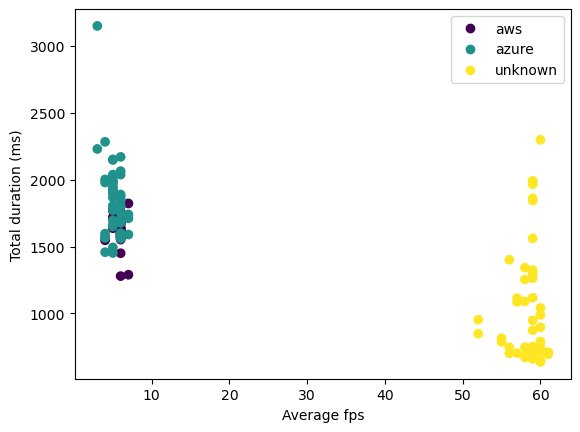

In [10]:
fig, ax = plt.subplots()
s = ax.scatter(
    df_combined['average_fps'],
    df_combined['total_duration_in_ms'],
    c=df_combined['provider'].cat.codes,
)
ax.set_xlabel('Average fps')
ax.set_ylabel('Total duration (ms)')
handles, _ = s.legend_elements(prop="colors")
legend1 = ax.legend(handles, df_combined['provider'].cat.categories)

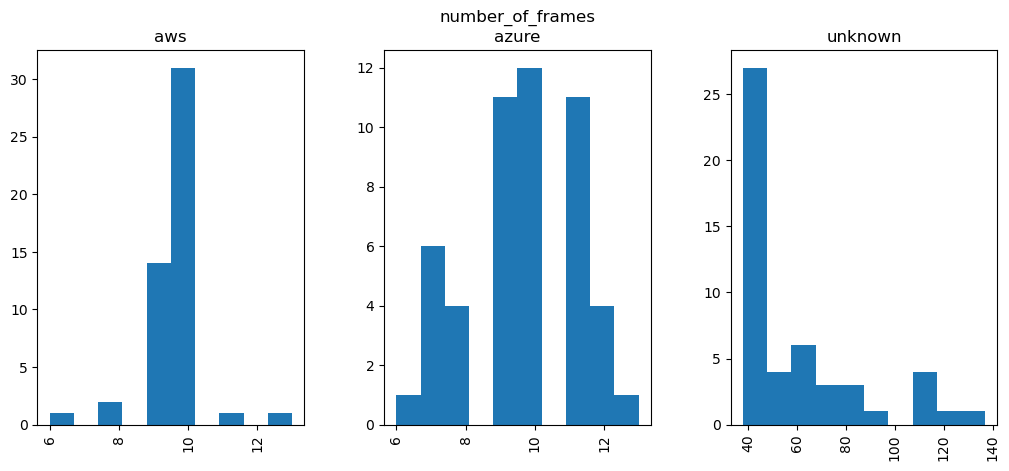

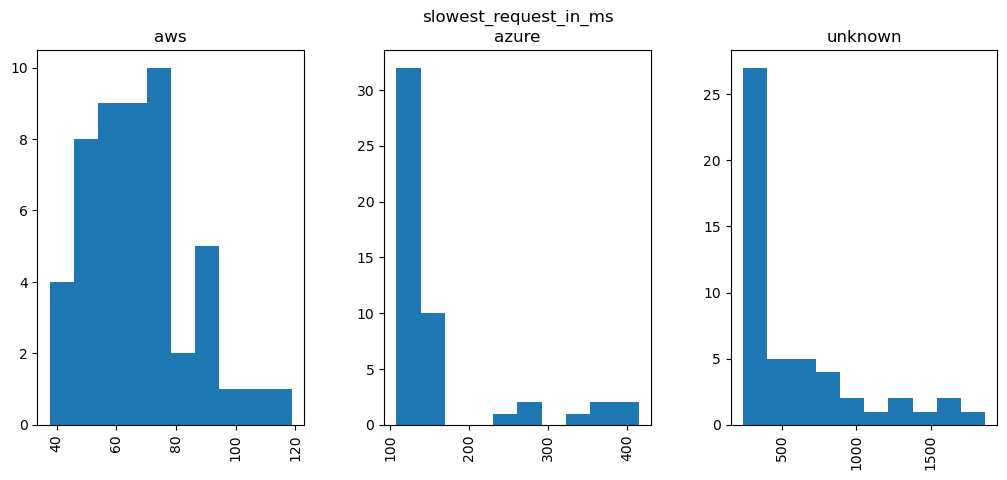

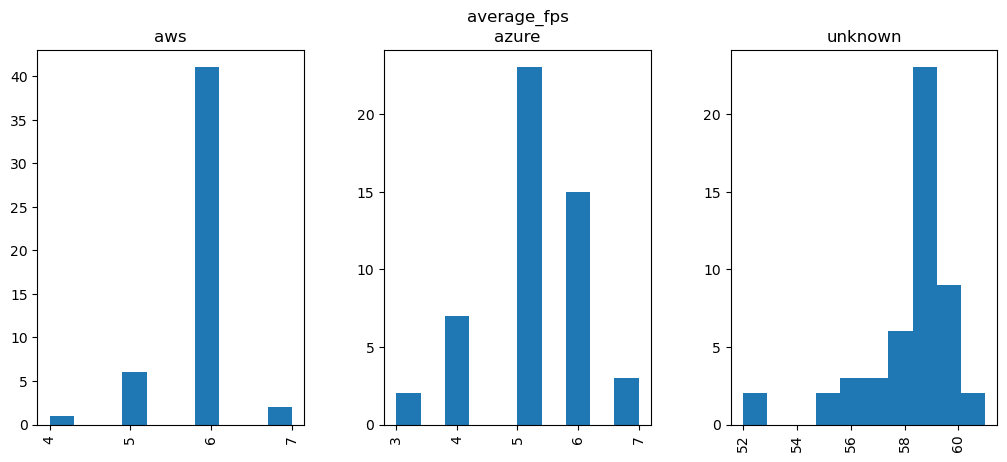

In [11]:
for metric in ['number_of_frames', 'slowest_request_in_ms', 'average_fps']:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
    df_combined[metric].hist(by=df_combined['provider'], ax=ax)
    plt.suptitle(metric)